In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from sklearn.linear_model import LinearRegression
import numpy as np
import json


data_path = "data/NPD_Data_2018_2019_V3.csv"
npd_data = pd.read_csv(data_path)


In [2]:
clean_data = npd_data.dropna()


API Call

In [3]:
import requests
import json
import gmaps

# Google API Key
from api_key import api

In [4]:
my_phrase = "Campgrounds near Shasta, CA"
target_url = "https://maps.googleapis.com/maps/api/place/textsearch/json"

params = {
    "query": my_phrase,
    "key": api
}

response = requests.get(target_url, params)

# print(response.url)
camps = response.json()
# print(json.dumps(camps, indent=4, sort_keys=True))

counter = 0
try:
    for place in camps["results"]:
        print(place["name"])
        print(place["formatted_address"])
        counter += 1
        if counter == 5:
            break
except KeyError as name:
    print("Skipping")

Sheep Camp
Shasta, CA 96087, United States
Peltier Bridge Campground
14412 Kennedy Memorial Dr, Whiskeytown, CA 96095, United States
Mountain Gate RV Park and Cottages
14161 Holiday Rd, Redding, CA 96003, United States
Chappie-Shasta Off-Highway Vehicle Area
Redding, CA 96001, United States
Redding RV Park
11075 Campers Ct, Redding, CA 96003, United States


In [5]:
gmaps.configure(api)



Purchase Method Graph

C:\Users\silve\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\silve\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


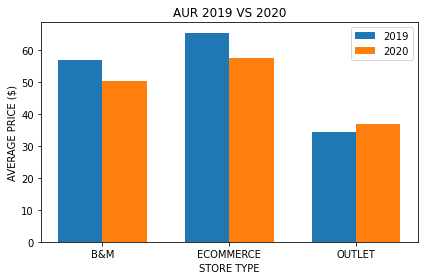

In [6]:
nineteen = clean_data[clean_data["Year"]==2019]
twenty = clean_data[clean_data["Year"]==2020]

nineteen_clothes = nineteen[(nineteen['Category'] == 'PANT/CAPRI') | (nineteen['Category'] == 'JACKET/VEST')]
twenty_clothes = twenty[(twenty['Category'] == 'PANT/CAPRI') | (twenty['Category'] == 'JACKET/VEST')]

nineteen_clothes['TY AUR'] = nineteen_clothes['TY AUR'].astype(float)
twenty_clothes['TY AUR'] = twenty_clothes['TY AUR'].astype(float)

nineteen_stores = round(nineteen_clothes.groupby(['StoreType']).mean(),2)
twenty_stores = round(twenty_clothes.groupby(['StoreType']).mean(),2)

store_type_aur = pd.concat([nineteen_stores, twenty_stores])

labels = ['B&M', 'ECOMMERCE', 'OUTLET']
x = np.arange(len(labels))
width = 0.35 
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, nineteen_stores["TY AUR"], width, label='2019')
rects2 = ax.bar(x + width/2, twenty_stores["TY AUR"], width, label='2020')


ax.set_title('AUR 2019 VS 2020')
ax.set_ylabel('AVERAGE PRICE ($)')
ax.set_xlabel('STORE TYPE')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
pd.set_option('mode.chained_assignment', None)
fig.tight_layout()
plt.savefig("Graphs/Purchase_Method")
plt.show()

Clothes Graph

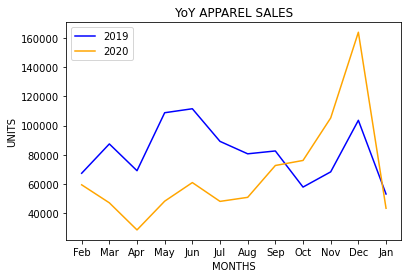

In [7]:
nineteen_clothes['Units'] = nineteen_clothes['Units'].str.replace(',', '').astype(float)
twenty_clothes['Units'] = twenty_clothes['Units'].str.replace(',', '').astype(float)

a = nineteen_clothes.groupby(['Month'],sort = False).sum()
b = twenty_clothes.groupby(['Month'], sort = False).sum()

plt.plot(a["Units"],color="blue")
plt.plot(b["Units"],color="orange")

pd.set_option('mode.chained_assignment', None)
plt.title("YoY APPAREL SALES")
plt.xlabel("MONTHS")
plt.ylabel("UNITS")
plt.legend(["2019","2020"])
plt.savefig("Graphs/clothes_sales")
plt.show()

Daypack Graphs

In [8]:
df1 = npd_data[npd_data['Category']=='DAYPACK']\
    .reset_index()\
    .copy()
df1 = df1\
    .drop(columns='TY AUR')\
    .assign(**{
    'Time': pd.to_datetime(df1['Month'].astype(str) + ' ' + df1['Year'].astype(str)),
    'Units': df1['Units'].str.replace('(','-').str.replace(')','').str.replace(',','').astype(int).fillna(0)})

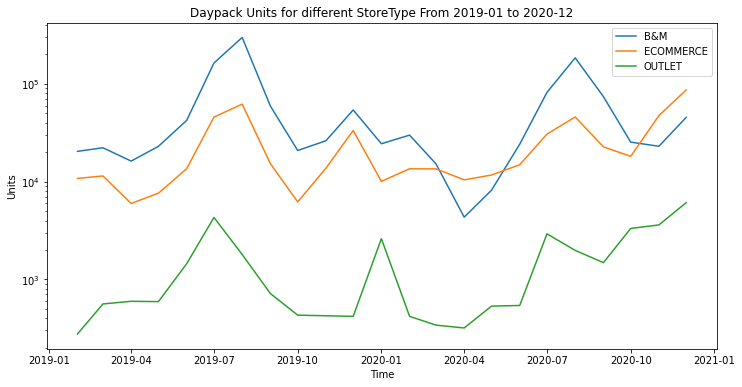

In [9]:
df2 = df1.groupby(['StoreType', 'Time']).agg({'Units':'sum'}).reset_index()
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for storetype in df2['StoreType'].unique().tolist():
    # storetype = 'ECOMMERCE'
    df3 = df2[(df2['StoreType']==storetype) & (df2['Time']>='2019-02-01') & (df2['Time']<'2020-12-31')].copy().reset_index()
    ax.plot(df3['Time'], df3['Units'], label=storetype)
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Time')
ax.set_ylabel('Units')
ax.set_title('Daypack Units for different StoreType From 2019-01 to 2020-12')
plt.savefig("Graphs/daypack_sales_by")

From this plot, we can find that:

Store type B&M and Ecommerce has yearly periodicity which is the units sales peak aroud June and July then dip around April; the outlet does not have the yearly periodicity.

The B&M and Ecommerce have the similar trends.

B&M has the deepest dip at 2020/April, I think there are 2 factors, one is due to seasonal influence, the other one is influneced by Covid-19.

At the same time, Ecommerce has the shallow dip at 2020/April. However, the dip is higher than that at the same time 2019, also higher than that of B&M at the same time, I believe the reason is more customers change their shopping behavoiur, more shopping online than come to shop.

For Outlet sales, from 2020 May, it went up, which is very different from that at the same time 2019.

In [10]:
df1['Month1'] = df1['Time'].astype(str).str[5:7]
df4_2019 = df1[(df1['Time']>='2019-01-01') & (df1['Time']<'2021-01-01')]\
            .sort_values(['Year','Month1'])\
            .groupby(['Year','Month1','Month'], sort=False)\
                .agg({'Units': 'sum'})\
                .reset_index()
df4_2019['Month1'] = df4_2019['Month1'].astype(int).apply(lambda x: (x + 10) % 12)
df4_2019 = df4_2019.sort_values(['Year', 'Month1']).reset_index(drop=True)

labels = df4_2019[df4_2019['Year'].astype(str)=='2019']['Month'].tolist()
df_19 = df4_2019[df4_2019['Year'].astype(str)=='2019']['Units'].tolist()
df_20 = df4_2019[df4_2019['Year'].astype(str)=='2020']['Units'].tolist()

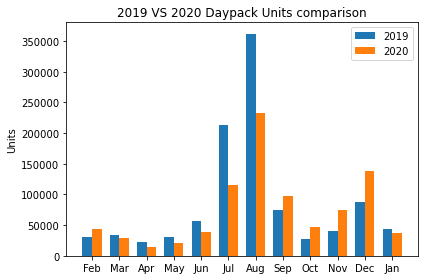

In [11]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, df_19, width, label='2019')
rects2 = ax.bar(x + width/2, df_20, width, label='2020')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Units')
ax.set_title('2019 VS 2020 Daypack Units comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()
plt.savefig("Graphs/daypack_units_year")
plt.show()

Camping Gear Graph

In [12]:
purchase_data_df = pd.DataFrame(npd_data)
#Remove commas from the numbers
npd_data['Units'] = npd_data['Units'].replace(',','', regex=True)

#Convert the Units column as int
npd_data['Units'] = npd_data['Units'].astype(float)
purchase_data_df.describe()

,Year,Units
count,43656.000000,43656.000000
mean,2019.496701,97.326507
std,0.499995,666.411671
min,2019.000000,-72.000000
25%,2019.000000,0.000000
50%,2019.000000,6.000000
75%,2020.000000,40.000000
max,2020.000000,59480.000000


In [13]:
camping_gear = purchase_data_df[['Month','Category','Units']]
camping_gear.head()

,Month,Category,Units
0,Feb,JACKET/VEST,0.0
1,Feb,PANT/CAPRI,14.0
2,Feb,JACKET/VEST,0.0
3,Feb,PANT/CAPRI,28.0
4,Feb,JACKET/VEST,2.0


In [14]:
months = purchase_data_df.groupby('Month')
months.size()

Month
Apr    3571
Aug    3580
Dec    3845
Feb    3402
Jan    3793
Jul    3596
Jun    3660
Mar    3367
May    3585
Nov    3832
Oct    3831
Sep    3594
dtype: int64

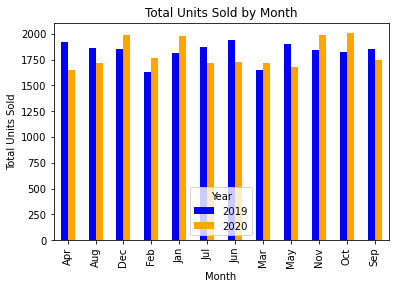

<Figure size 432x288 with 0 Axes>

In [15]:
retail = months.sum()
data_points = purchase_data_df.groupby(["Year","Month"]).count()["Category"]

data_points.unstack(0).plot(kind="bar", color=['blue','orange'])
plt.title("Total Units Sold by Month")
plt.ylabel("Total Units Sold")
pd.set_option('mode.chained_assignment', None)
plt.show()


# Save the plotted figure as .pngs
plt.savefig('Graphs/camping_gear')

In [16]:
nineteen_tent = nineteen[(nineteen['Category'] == 'TENT') | (nineteen['Category'] == 'TENT')]
twenty_bag = twenty[(twenty['Category'] == 'SLEEPING BAG') | (twenty['Category'] == 'SLEEPING BAG')]

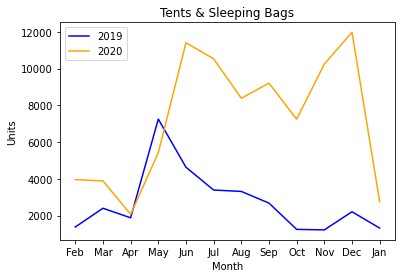

<Figure size 432x288 with 0 Axes>

In [17]:
nineteen_tent['Units'] = nineteen_tent['Units'].str.replace(',', '').astype(float)
twenty_bag['Units'] = twenty_bag['Units'].str.replace(',', '').astype(float)

a = nineteen_tent.groupby(['Month'],sort = False).sum()
b = twenty_bag.groupby(['Month'], sort = False).sum()

plt.plot(a["Units"],color="blue")
plt.plot(b["Units"],color="orange")
plt.legend(["2019","2020"])
plt.title("Tents & Sleeping Bags")
plt.xlabel("Month")
plt.ylabel("Units")
pd.set_option('mode.chained_assignment', None)
plt.show()

# Save the plotted figure as .pngs
plt.savefig('Graphs/Tents_sleeping')

Total Units Sold Graph

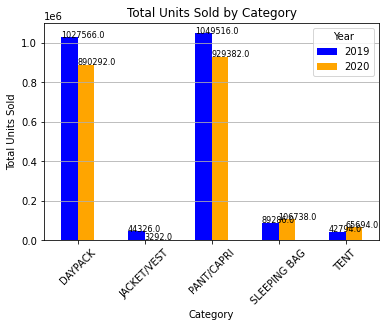

<Figure size 432x288 with 0 Axes>

In [18]:
#Group by year and category
grp_cat = npd_data.groupby(["Year", "Category"])

#Get the sum of the units in the new groupby object
sum_by_cat = grp_cat['Units'].sum()
sum_by_cat

#Create bar plot
ax = sum_by_cat.unstack(0).plot(kind="bar", rot=45, color=["blue", "orange"])
plt.xlabel("Category")
plt.ylabel("Total Units Sold")
plt.title("Total Units Sold by Category")

#Add the total values on the chart
for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), \
           str(round((i.get_height()), 2)), fontsize=8, color="black")
    
plt.grid(axis="y")
plt.savefig('Graphs/total_units')
plt.show()
plt.tight_layout()

In [19]:
sum_table = sum_by_cat.unstack(0)
sum_table.columns.name = None

#Create a column for the percent change
sum_table['Percent Change'] = round((sum_table[2020] - sum_table[2019]) / sum_table[2019] * 100, 2)

#Reset index
sum_table = sum_table.reset_index()

#Get the sum of all the values
ttotal = sum_table.sum()

#Gets the total percentage change
total_change = round(((ttotal[2020] - ttotal[2019]) / ttotal[2019])*100, 2)

#Adds a new row below everything have the total values
sum_table = sum_table.append({'Category': 'TOTAL'}, ignore_index=True)

#Adds the totals in the dataframe
sum_table.iloc[5,1] = ttotal[2019]
sum_table.iloc[5,2] = ttotal[2020]
sum_table.iloc[5,3] = total_change

#Set the index to be category to get rid of index number
sum_table = sum_table.set_index('Category')
sum_table

,2019,2020,Percent Change
Category,,,
DAYPACK,1027566.0,890292.0,-13.36
JACKET/VEST,44326.0,3292.0,-92.57
PANT/CAPRI,1049516.0,929382.0,-11.45
SLEEPING BAG,89286.0,106738.0,19.55
TENT,42794.0,65694.0,53.51
TOTAL,2253488.0,1995398.0,-11.45


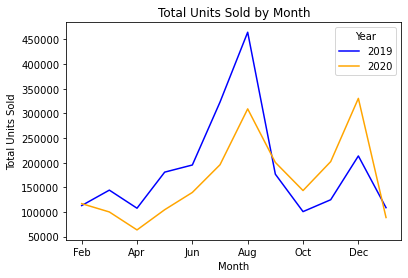

<Figure size 432x288 with 0 Axes>

In [20]:
#Total Units of Camping Equipment Sold
#Group by year and month
month_df = npd_data.groupby(['Year', 'Month'], sort=False).sum()

#Create line chart
month_df.unstack(0).plot(kind="line", y='Units', color=['blue','orange'])
plt.title("Total Units Sold by Month")
plt.ylabel("Total Units Sold")
plt.savefig('Graphs/total_units_month')
plt.show()
plt.tight_layout()